# Домашнее задание NLP 2
Практика по PyTorch

**Цель:**
В этом ДЗ вы попрактикуетесь с PyTorch.

<hr>

**Описание/Пошаговая инструкция выполнения домашнего задания:**

1. Используя PyTorch, создать и обучить регрессионную модель, которая аппроксимирует значение функции sin(x + 2*y)exp(-(2x + y)^2) на диапазоне значений [-10;10] по х и у.В качестве обучающей выборки необходимо сгенерировать 20000 точек случайным образом.
2. Разделить получившийся датасет на train / test / val в отношениях 70% / 15% / 15%, соответственно.
3. Результаты:
<li> a) Посчитать метрику Mean Square Error(MSE) на test.
<li> b) Нарисовать график, в котором сравнивается истинная функция и ее аппроксимированный вариант (предсказываемый моделью).

**Критерии оценки:**
<li> +7 балла за (a)
<li>  +3 балл за (b)
Максимальный балл: 10

Первым шагом сгенирируем значения для x и y, соединим их в единый список и посчитаем значение функции.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import torch
import pandas as pd

In [2]:
X = [random.uniform(-10,10) for i in range(20000)]
Y = [random.uniform(-10,10) for i in range(20000)]
z = [np.sin(x+2*y) * np.exp(-(2*x + y)**2) for x,y in zip(X,Y)]
X_comb = np.array([list(i) for i in zip(X,Y)])

print(len(X), len(Y), len(X_comb), len(z))

20000 20000 20000 20000


In [3]:
view = px.scatter_3d(x = X,
                y = Y,
                z = z,
                title = 'Generated Data incl. function results')
view.show()

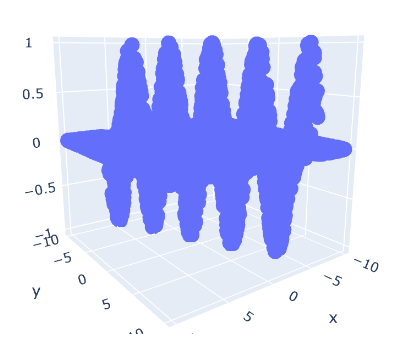

Прикладываю принт-скрин самого графика, так как визуализации в plotly исчезают после закрытия ноутбука :(, а обычный matplotlib у меня почему-то не работает с таким кол-вом данных.

Итак, результат работы функции в большинтсве случаев приводит к очень маленькому значению функции. Высока вероятность, что модель будет предсказывать как раз только минимальные значения, так как это доминирующие значение.

Посмотрим еще на 2D представление результата, чтобы понять, где наибольшая плотность.

In [4]:
t = np.linspace(0,20000, num = 20000).astype(int)
fig = px.scatter(x = t,
                 y = z)
fig.show()

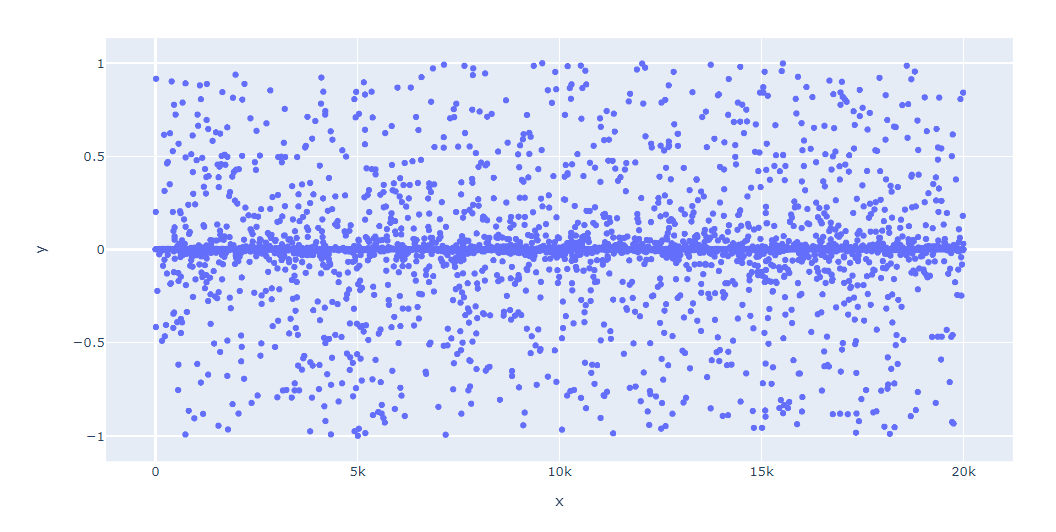

Следующий шаг - разобъем данные на 3 части: train, test and validation. Так как данные у нас сгенерировались случайно, то не играет роли как их разбивать. Будем разбивать по-порядку следования.

Перед разбивкой переведем данные в тензоры для работы с pytorch.

In [5]:
def split(arr):
    train  = arr[:int(len(arr)*0.7)]
    test = arr[int(len(arr)*0.7):int(len(arr)*0.85)]
    val = arr[int(len(arr)*0.85):]
    return train, test, val

In [6]:
X = torch.tensor(X_comb).type(torch.float32)
X_train, X_test, X_val = split(X)
y = torch.tensor(np.array(z))
y_train, y_test, y_val = split(y)

print(f'X_train:{X_train.shape}, X_test:{X_test.shape}, X_val:{X_val.shape}')
print(f'y_train:{y_train.shape}, y_test:{y_test.shape}, y_val:{y_val.shape}')

X_train:torch.Size([14000, 2]), X_test:torch.Size([3000, 2]), X_val:torch.Size([3000, 2])
y_train:torch.Size([14000]), y_test:torch.Size([3000]), y_val:torch.Size([3000])


Создадим из полученных данных датасеты и завернем их в DataLoader.

In [7]:
import torch.utils.data as data_utils

train = data_utils.TensorDataset(X_train, y_train)
test = data_utils.TensorDataset(X_test, y_test)

train_loader = data_utils.DataLoader(train, batch_size = 64, shuffle = True)
test_loader = data_utils.DataLoader(test, batch_size = 64, shuffle = False)

In [8]:
# Examine a sample
data, labels = next(iter(train_loader))
print(data.dtype)
print(data.shape)
print(labels.shape)

torch.float32
torch.Size([64, 2])
torch.Size([64])


Подготовим сеть, в которой будет 3 полносвязных линейных слоя, переложенных ReLu слоями.

In [9]:
from torch import nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)


        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x   

print(Net())    

Net(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


Переведем все данные для расчетов на GPU, инициализируем оптимайзер и напишем функцию потерь

In [10]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [12]:
def loss(pred, target):
    squares = (pred - target) ** 2
    return squares.mean()

Запустим обучение и будем проверять результаты обучения на тестовом датасете каждые 500 шагов обучения.

In [13]:
epochs = 150
steps = 0
print_fr = 1500

for epoch in range(epochs):
    running_loss = 0
    for data, label in train_loader:
        steps += 1
        model.train()
        data = data.to(device)
        label = label.to(device)
        pred = model(data)
        loss_train = loss(pred, label)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        #optimizer.param_groups[0]['lr'] = 0.001
                
        running_loss += loss_train.item()

        
        if steps % print_fr == 0:
            with torch.no_grad():
                model.eval()
                for data, label in test_loader:
                    data = data.to(device)
                    label = label.to(device)
                    pred = model(data)
                    loss_test = loss(pred, label)

                model.train()

                print(f'Epoch:{epoch} , Test Loss: {loss_test}')

Epoch:6 , Test Loss: 1.6193224297263378
Epoch:13 , Test Loss: 0.7083435541913368
Epoch:20 , Test Loss: 0.29211687285294635
Epoch:27 , Test Loss: 0.12237934327058643
Epoch:34 , Test Loss: 0.05687029544073488
Epoch:41 , Test Loss: 0.03833221220660151
Epoch:47 , Test Loss: 0.035415088767927684
Epoch:54 , Test Loss: 0.03389720842416342
Epoch:61 , Test Loss: 0.03248021971360325
Epoch:68 , Test Loss: 0.03141975034406017
Epoch:75 , Test Loss: 0.030786024459067838
Epoch:82 , Test Loss: 0.0304352878837617
Epoch:89 , Test Loss: 0.030170281999508372
Epoch:95 , Test Loss: 0.029925135439669206
Epoch:102 , Test Loss: 0.029850012493532103
Epoch:109 , Test Loss: 0.02988104535477269
Epoch:116 , Test Loss: 0.02979134921380312
Epoch:123 , Test Loss: 0.029835219672112532
Epoch:130 , Test Loss: 0.02971139756349637
Epoch:136 , Test Loss: 0.02969954645271825
Epoch:143 , Test Loss: 0.029680170384064942


Переведем модель в режим инференса и сделаем предсказания для валидационного датасета. Попробуем изобразить оба массива данных на графике.

In [14]:
model.eval()
with torch.no_grad():
    pred = model(X_val.to(device))
    
prediction = []
for i in (pred.cpu().numpy()):
    prediction.append(i[0])

In [15]:
import plotly.graph_objects as go
t = np.linspace(0,3000, num = 3000).astype(int)
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=prediction,
                    mode='markers',
                    name='prediction'))
fig.add_trace(go.Scatter(x=t, y=y_val.numpy(),
                    mode='markers',
                    name='ground truth',
                    line=dict(color='rgba(200, 0, 0, 0.14)')))

fig.update_layout(title=f'Loss on validation dataset: {round(loss(prediction,y_val.numpy()),4)}',
                   xaxis_title='Number of points',
                   yaxis_title='Function value')
fig.show()

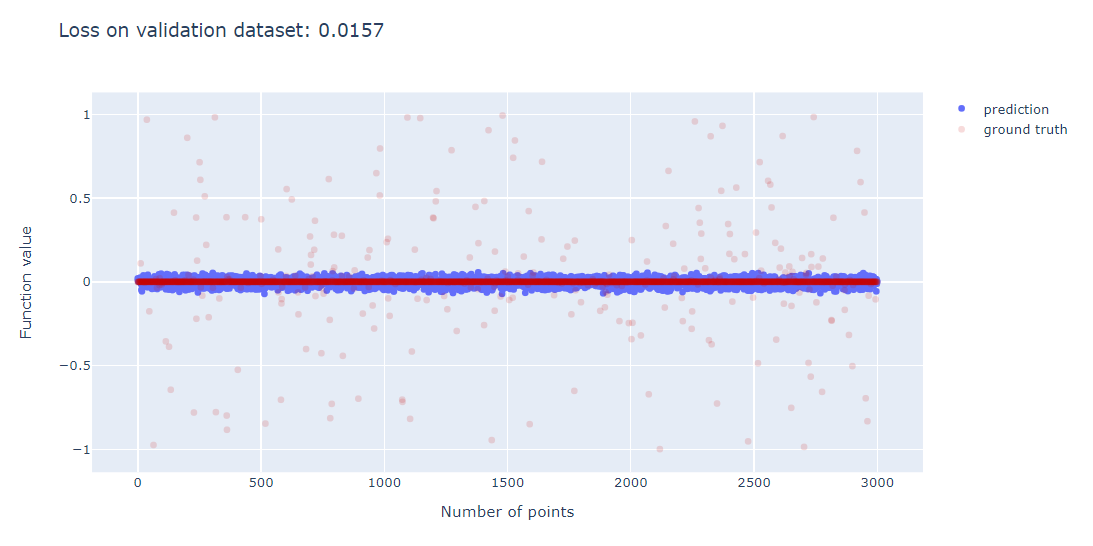

# Выводы:

Модель научилась предсказывать точки, котоорые лежат близ нуля, но результат с точками, которые дальше - намного хуже. С другой стороны, большинство точек лежит близ нуля. Но все-таки ошибка MSE для валидационного сета слишком большая.